In [15]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [33]:
# Find the most recent date in the data set.
recent_data = session.query(measurement)

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame and set the index to the date column


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data




In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number station's in the dataset
station_count = session.query(func.count(station.station)).all()
station_count

[(9)]

In [96]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations_count = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [98]:
# List first row to find most active station number and count
most_active = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
most_active

('USC00519281', 2772)

In [99]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#lowest temperature
lowest_temp = session.query(measurement.station, func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
lowest_temp

[('USC00519281', 54.0)]

In [100]:
#highest temperature
highest_temp = session.query(measurement.station, func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
highest_temp

[('USC00519281', 85.0)]

In [101]:
#average temperature
avg_temp = session.query(measurement.station, func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
avg_temp

[('USC00519281', 71.66378066378067)]

In [114]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# design a query to find the last year of temperature observation data in data for the most active station id
dates = session.query(measurement.date).filter(measurement.station == 'USC00519281').order_by((measurement.date).desc()).first()
dates

('2017-08-18')

In [131]:
# query data to find last 12 months of temperature observation data
results = session.query(measurement.station, measurement.date, measurement.tobs).filter(measurement.station == 'USC00519281').filter(func.strftime("%Y", measurement.date) == "2017").order_by(measurement.date).all()
results[1]

('USC00519281', '2017-01-02', 70.0)

In [138]:
# put date and temperature results into two lists
dates = [result[1] for result in results]
temperatures = [int(result[2]) for result in results]

<BarContainer object of 221 artists>

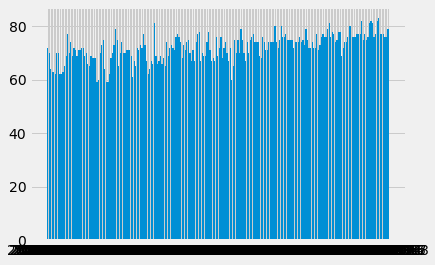

In [139]:
# plot results as a histogram
fig, ax = plt.subplots()
ax.bar(dates, temperatures)

# Close session

In [ ]:
# Close Session
session.close()